In [ ]:
!pip install matplotlib seaborn plotly wordcloud networkx folium geopy spacy scikit-learn
!python -m spacy download en_core_web_sm

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from wordcloud import WordCloud
import spacy
import folium
from geopy.geocoders import Nominatim
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time

warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Miki_class/Project/Catalog/processed_ads/ads_features.csv')

In [ ]:
print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print("\nDataset overview:")
print(df.info())

Dataset loaded: 2725 rows, 48 columns

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   filename               2725 non-null   object 
 1   ad_type                2725 non-null   object 
 2   issue                  2725 non-null   object 
 3   issue_date             1925 non-null   object 
 4   image_path             2725 non-null   object 
 5   width                  2725 non-null   int64  
 6   height                 2725 non-null   int64  
 7   aspect_ratio           2725 non-null   float64
 8   is_greyscale           2725 non-null   bool   
 9   text_heb_raw           2725 non-null   object 
 10  text_eng_raw           2725 non-null   object 
 11  text_heb_clean         2442 non-null   object 
 12  text_eng_clean         2390 non-null   object 
 13  text_heb_length        2725 non-null   int64  
 14 

In [ ]:
print("Missing values per column:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

Missing values per column:
                 Missing Count  Missing Percentage
avg_price                 2192           80.440367
min_price                 2192           80.440367
max_price                 2192           80.440367
days_to_holiday           1725           63.302752
issue_date                 800           29.357798
weekday                    800           29.357798
text_eng_clean             335           12.293578
text_heb_clean             283           10.385321
text_embeddings            283           10.385321


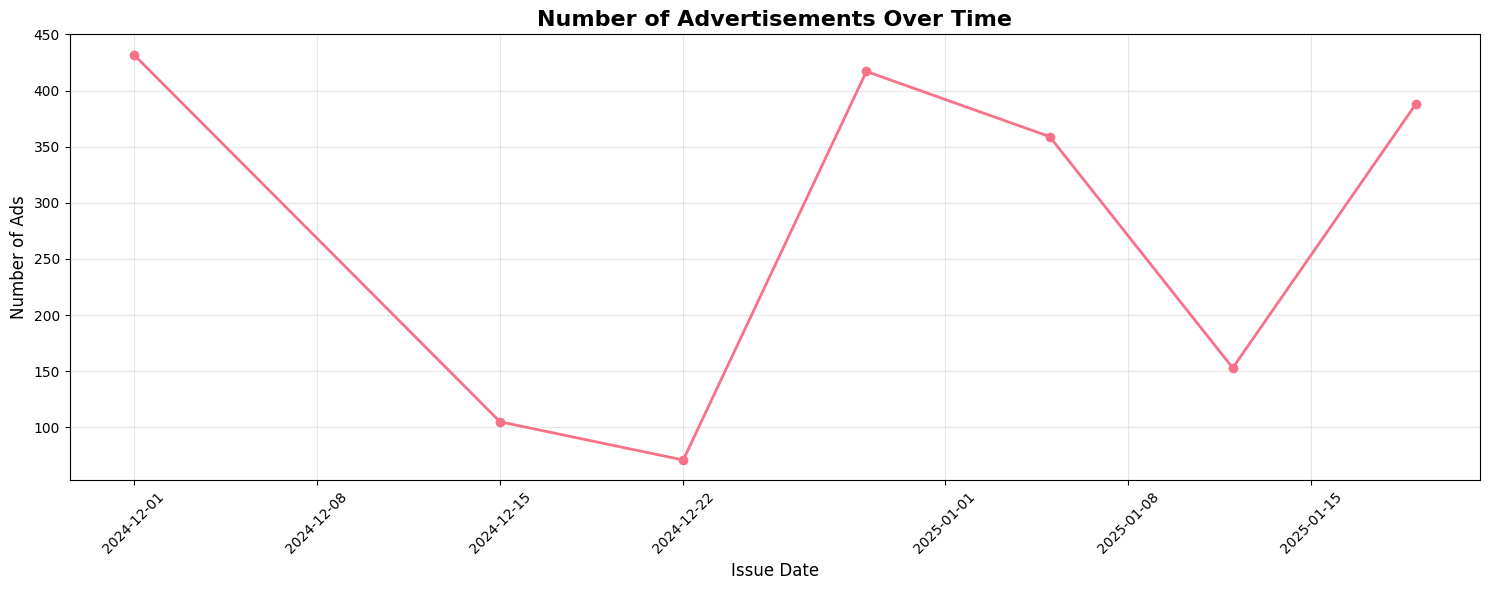

In [ ]:
df['issue_date'] = pd.to_datetime(df['issue_date'])

# Count ads per issue
ads_per_issue = df.groupby(['issue', 'issue_date']).size().reset_index(name='ad_count')
ads_per_issue = ads_per_issue.sort_values('issue_date')

plt.figure(figsize=(15, 6))
plt.plot(ads_per_issue['issue_date'], ads_per_issue['ad_count'], marker='o', linewidth=2, markersize=6)
plt.title('Number of Advertisements Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Issue Date', fontsize=12)
plt.ylabel('Number of Ads', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Average ads per issue: {ads_per_issue['ad_count'].mean():.1f}")
print(f"Peak issue: {ads_per_issue.loc[ads_per_issue['ad_count'].idxmax(), 'issue']} with {ads_per_issue['ad_count'].max()} ads")

Average ads per issue: 275.0
Peak issue: 1197 with 432 ads


In [ ]:
fig = px.line(ads_per_issue, x='issue_date', y='ad_count',
              title='Interactive Timeline: Number of Advertisements Over Time',
              labels={'issue_date': 'Issue Date', 'ad_count': 'Number of Ads'})
fig.update_traces(mode='lines+markers')
fig.show()

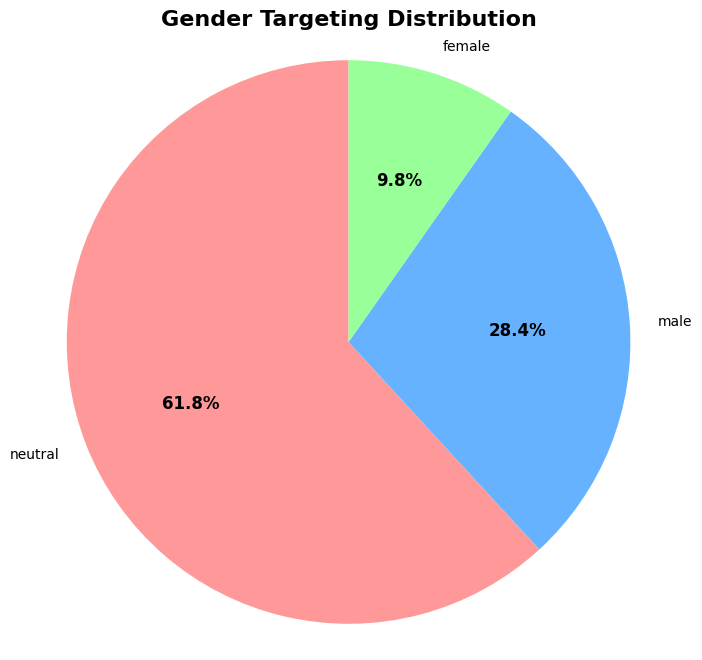

In [ ]:
gender_counts = df['gender_target'].value_counts()

plt.figure(figsize=(8, 8))
colors = ['#FF9999', '#66B2FF', '#99FF99']
wedges, texts, autotexts = plt.pie(gender_counts.values, labels=gender_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Gender Targeting Distribution', fontsize=16, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.axis('equal')
plt.show()

In [ ]:
for gender, count in gender_counts.items():
    print(f"  {gender}: {count} ads ({count/len(df)*100:.1f}%)")

  neutral: 1685 ads (61.8%)
  male: 774 ads (28.4%)
  female: 266 ads (9.8%)


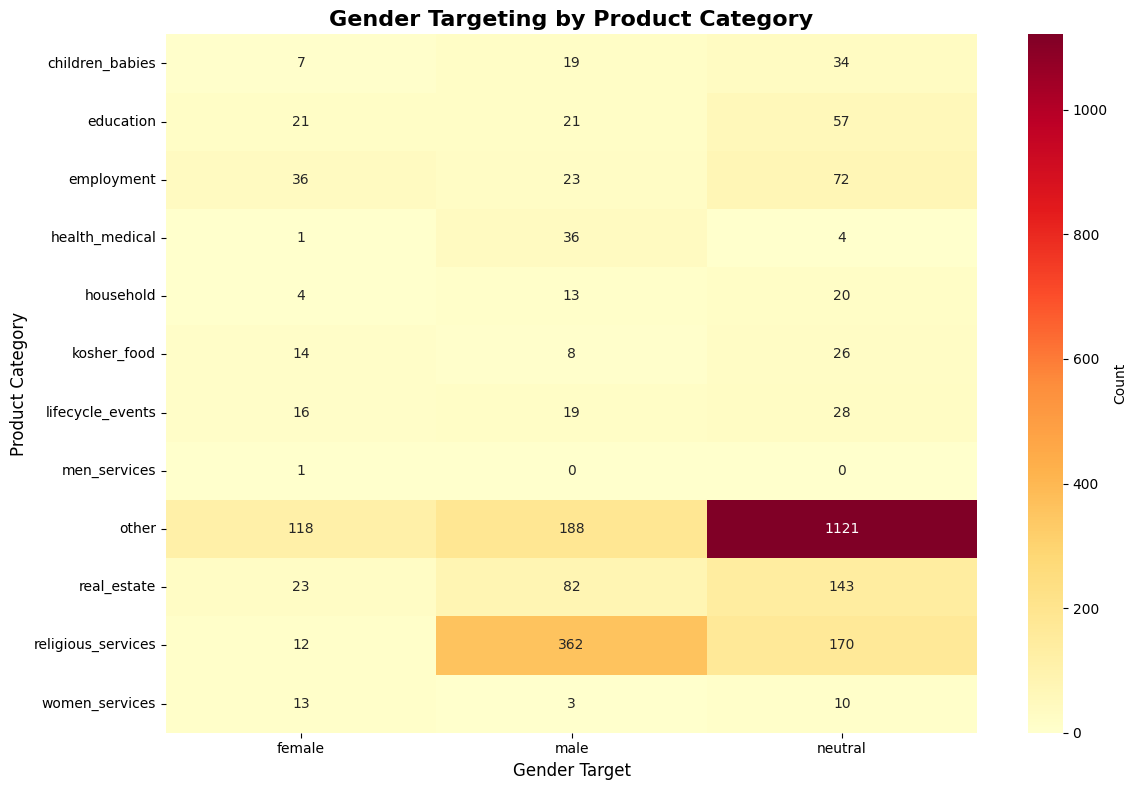

In [ ]:
gender_category = pd.crosstab(df['product_category'], df['gender_target'], margins=True)

plt.figure(figsize=(12, 8))
sns.heatmap(gender_category.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Gender Targeting by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Gender Target', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

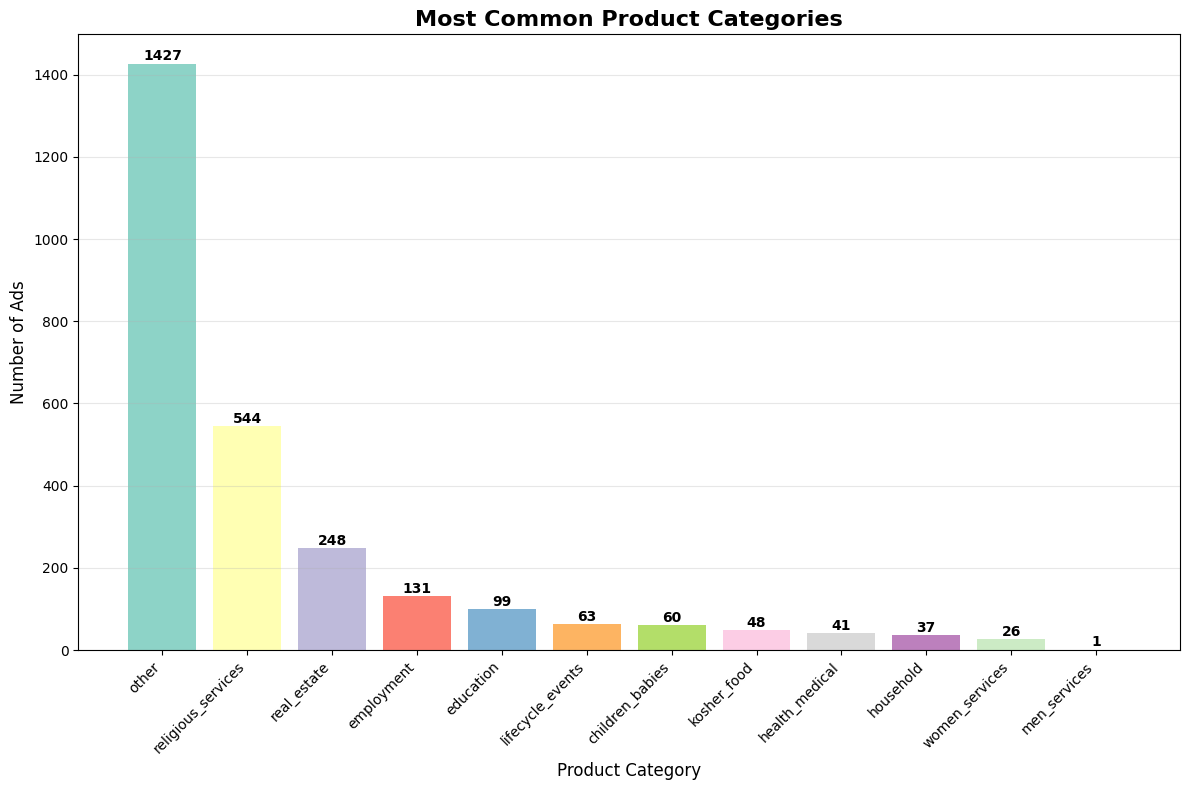

In [ ]:
category_counts = df['product_category'].value_counts()

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(category_counts)), category_counts.values,
               color=plt.cm.Set3(np.linspace(0, 1, len(category_counts))))
plt.title('Most Common Product Categories', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Ads', fontsize=12)
plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

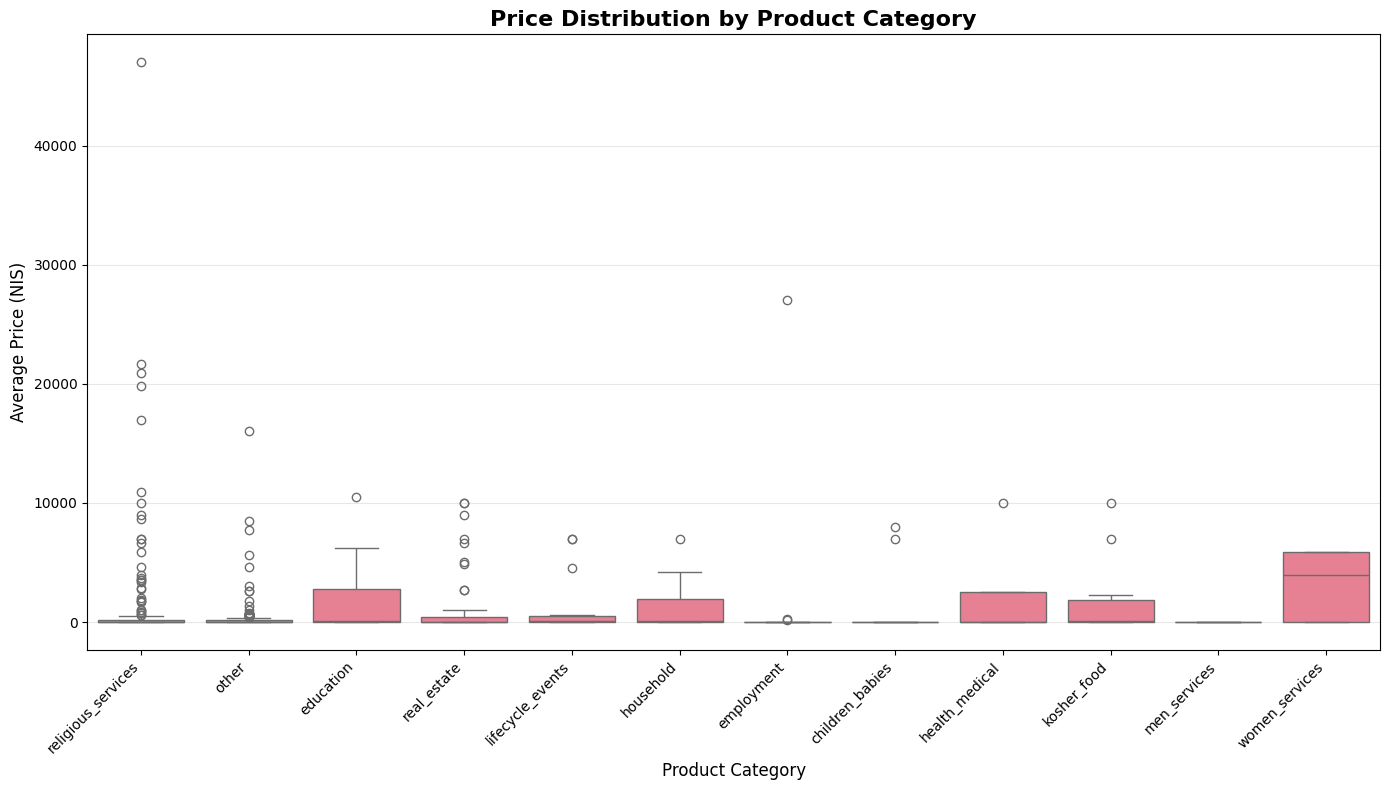


Pricing insights:
Total ads with prices: 533
Highest priced category: women_services (avg: 3128.33 NIS)
Lowest priced category: men_services (avg: 5.00 NIS)


In [ ]:
df_with_prices = df[df['price_count'] > 0].copy()

if len(df_with_prices) > 0:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_with_prices, x='product_category', y='avg_price')
    plt.title('Price Distribution by Product Category', fontsize=16, fontweight='bold')
    plt.xlabel('Product Category', fontsize=12)
    plt.ylabel('Average Price (NIS)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nPricing insights:")
    print(f"Total ads with prices: {len(df_with_prices)}")
    price_by_category = df_with_prices.groupby('product_category')['avg_price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    print(f"Highest priced category: {price_by_category.index[0]} (avg: {price_by_category.iloc[0]['mean']:.2f} NIS)")
    print(f"Lowest priced category: {price_by_category.index[-1]} (avg: {price_by_category.iloc[-1]['mean']:.2f} NIS)")
else:
    print("No pricing data available for analysis")

In [ ]:
holiday_comparison = df.groupby('is_near_holiday').agg({
    'ad_type': 'count',
    'has_discount': 'sum',
    'price_count': 'mean'
}).rename(columns={'ad_type': 'total_ads'})

In [ ]:
print("\n=== HOLIDAY EFFECTS ===")
print(holiday_comparison)


=== HOLIDAY EFFECTS ===
                 total_ads  has_discount  price_count
is_near_holiday                                      
False                 1725           249     0.403478
True                  1000            47     0.154000


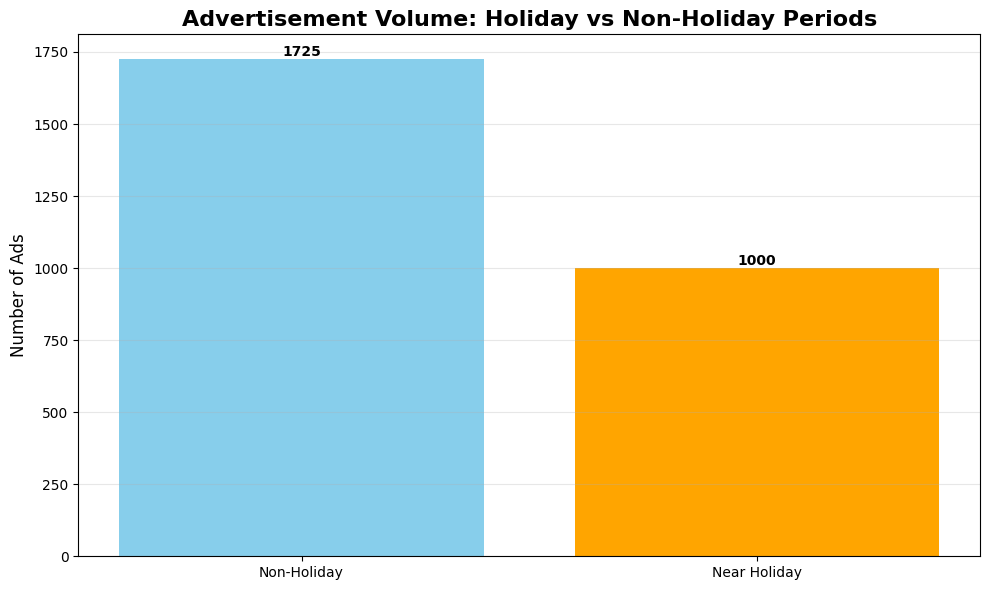

In [ ]:
plt.figure(figsize=(10, 6))
x_labels = ['Non-Holiday', 'Near Holiday']
ad_counts = [holiday_comparison.loc[False, 'total_ads'], holiday_comparison.loc[True, 'total_ads']]

bars = plt.bar(x_labels, ad_counts, color=['skyblue', 'orange'])
plt.title('Advertisement Volume: Holiday vs Non-Holiday Periods', fontsize=16, fontweight='bold')
plt.ylabel('Number of Ads', fontsize=12)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

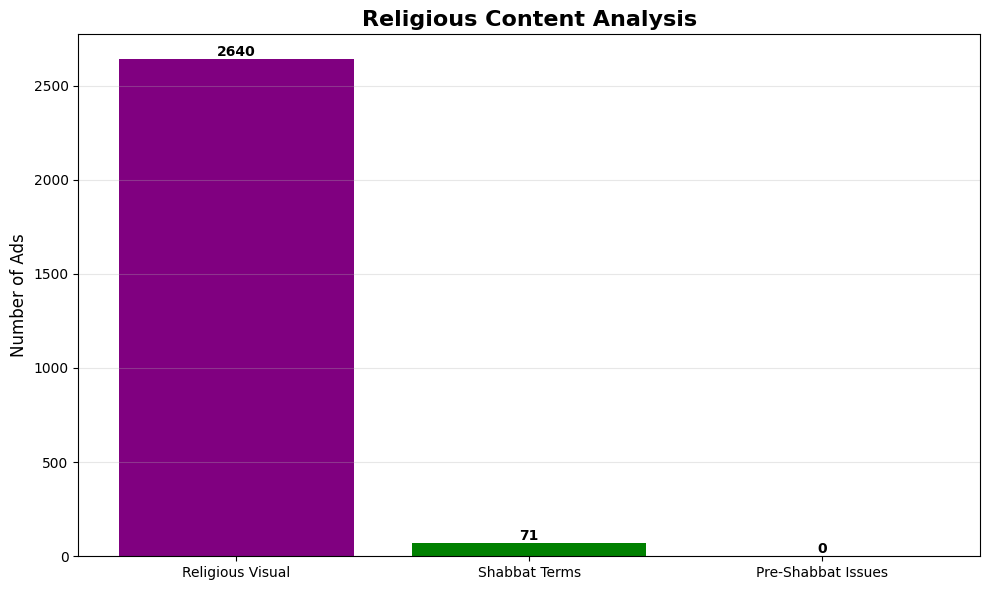

In [ ]:
religious_analysis = {
    'Religious Visual Content': df['is_religious_visual'].sum() if 'is_religious_visual' in df.columns else 0,
    'Shabbat Terms': df['has_shabbat_terms'].sum(),
    'Pre-Shabbat Issues': df['is_pre_shabbat'].sum(),
    'Total Ads': len(df)
}

plt.figure(figsize=(10, 6))
categories = ['Religious Visual', 'Shabbat Terms', 'Pre-Shabbat Issues']
counts = [religious_analysis['Religious Visual Content'],
          religious_analysis['Shabbat Terms'],
          religious_analysis['Pre-Shabbat Issues']]

bars = plt.bar(categories, counts, color=['purple', 'green', 'red'])
plt.title('Religious Content Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Number of Ads', fontsize=12)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Religious content insights:")
for key, value in religious_analysis.items():
    if key != 'Total Ads':
        percentage = (value / religious_analysis['Total Ads']) * 100
        print(f"  {key}: {value} ads ({percentage:.1f}%)")

Religious content insights:
  Religious Visual Content: 2640 ads (96.9%)
  Shabbat Terms: 71 ads (2.6%)
  Pre-Shabbat Issues: 0 ads (0.0%)


In [ ]:
def get_color_warmth(colors_str):
    if pd.isna(colors_str) or colors_str == '[]':
        return 'unknown'

    try:
        colors = eval(colors_str)
        if not colors:
            return 'unknown'

        warm_colors = 0
        cool_colors = 0

        for color in colors:
            r, g, b = color
            # Simple heuristic: warm if red > blue, cool if blue > red
            if r > b:
                warm_colors += 1
            elif b > r:
                cool_colors += 1

        if warm_colors > cool_colors:
            return 'warm'
        elif cool_colors > warm_colors:
            return 'cool'
        else:
            return 'neutral'
    except:
        return 'unknown'

In [ ]:
df['color_warmth'] = df['main_colors'].apply(get_color_warmth)

<Figure size 1000x600 with 0 Axes>

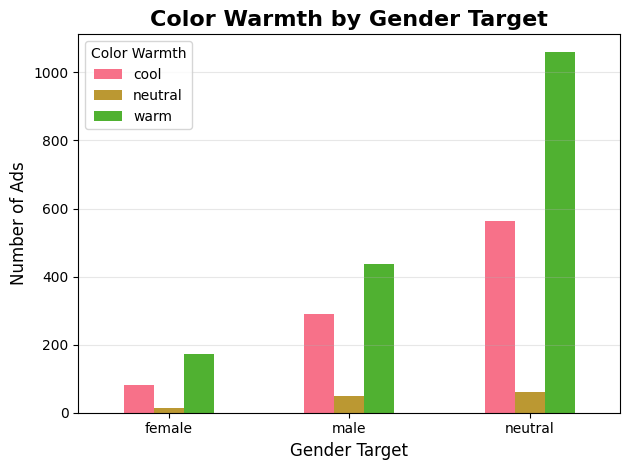

In [ ]:
gender_color = pd.crosstab(df['gender_target'], df['color_warmth'])

plt.figure(figsize=(10, 6))
gender_color.plot(kind='bar', stacked=False)
plt.title('Color Warmth by Gender Target', fontsize=16, fontweight='bold')
plt.xlabel('Gender Target', fontsize=12)
plt.ylabel('Number of Ads', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Color Warmth')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

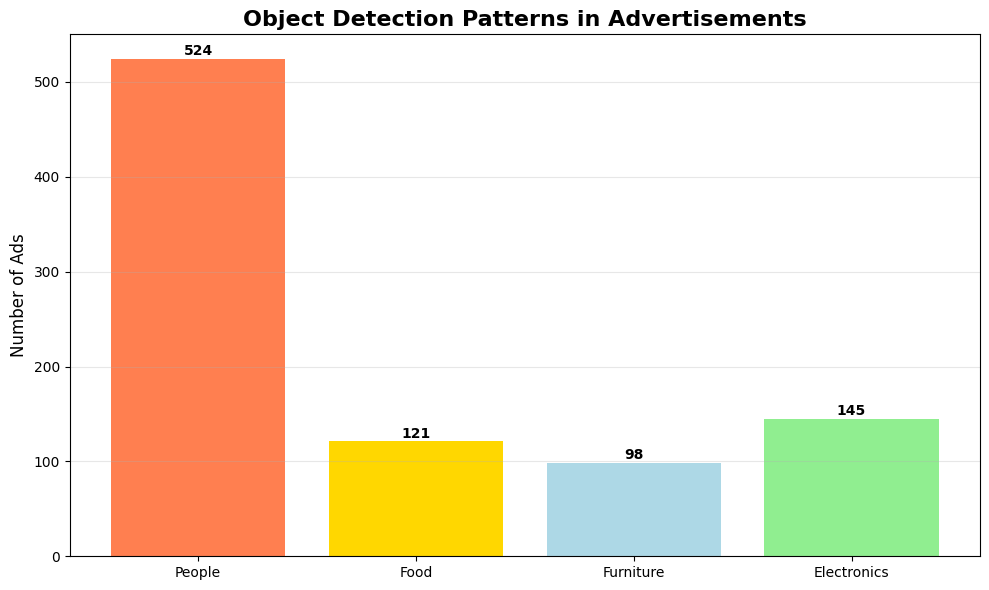

In [ ]:
if 'has_people' in df.columns:
    object_patterns = {
        'People': df['has_people'].sum(),
        'Food': df['has_food'].sum(),
        'Furniture': df['has_furniture'].sum(),
        'Electronics': df['has_electronics'].sum()
    }

    plt.figure(figsize=(10, 6))
    categories = list(object_patterns.keys())
    counts = list(object_patterns.values())

    bars = plt.bar(categories, counts, color=['coral', 'gold', 'lightblue', 'lightgreen'])
    plt.title('Object Detection Patterns in Advertisements', fontsize=16, fontweight='bold')
    plt.ylabel('Number of Ads', fontsize=12)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Object detection data not available")

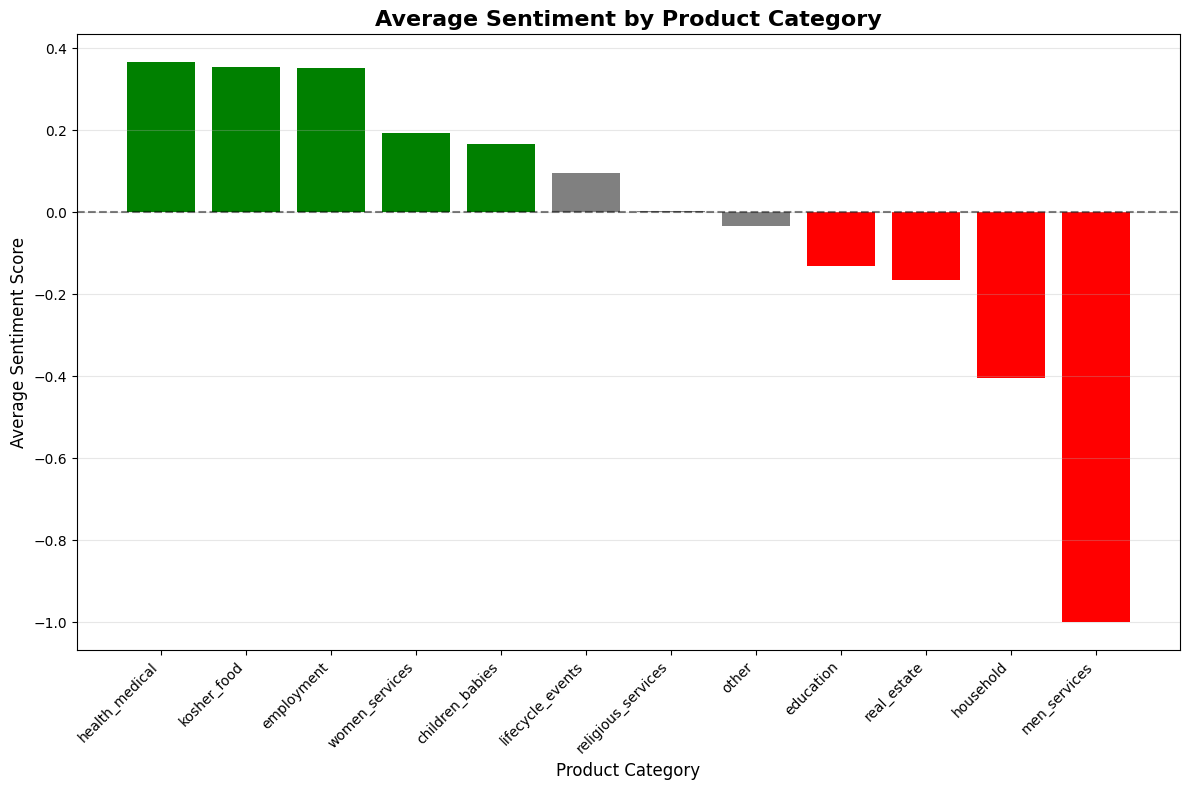

Most positive categories:
product_category
health_medical    0.365854
kosher_food       0.354167
employment        0.351145
Name: sentiment_numeric, dtype: float64

Most negative categories:
product_category
real_estate    -0.165323
household      -0.405405
men_services   -1.000000
Name: sentiment_numeric, dtype: float64


In [ ]:
if 'sentiment_advanced' in df.columns:
    # Map sentiment to numeric values
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    df['sentiment_numeric'] = df['sentiment_advanced'].map(sentiment_mapping)

    sentiment_by_category = df.groupby('product_category')['sentiment_numeric'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(sentiment_by_category)), sentiment_by_category.values,
                   color=['green' if x > 0.1 else 'red' if x < -0.1 else 'gray' for x in sentiment_by_category.values])
    plt.title('Average Sentiment by Product Category', fontsize=16, fontweight='bold')
    plt.xlabel('Product Category', fontsize=12)
    plt.ylabel('Average Sentiment Score', fontsize=12)
    plt.xticks(range(len(sentiment_by_category)), sentiment_by_category.index, rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Most positive categories:")
    print(sentiment_by_category.head(3))
    print("\nMost negative categories:")
    print(sentiment_by_category.tail(3))
else:
    print("Sentiment analysis data not available")

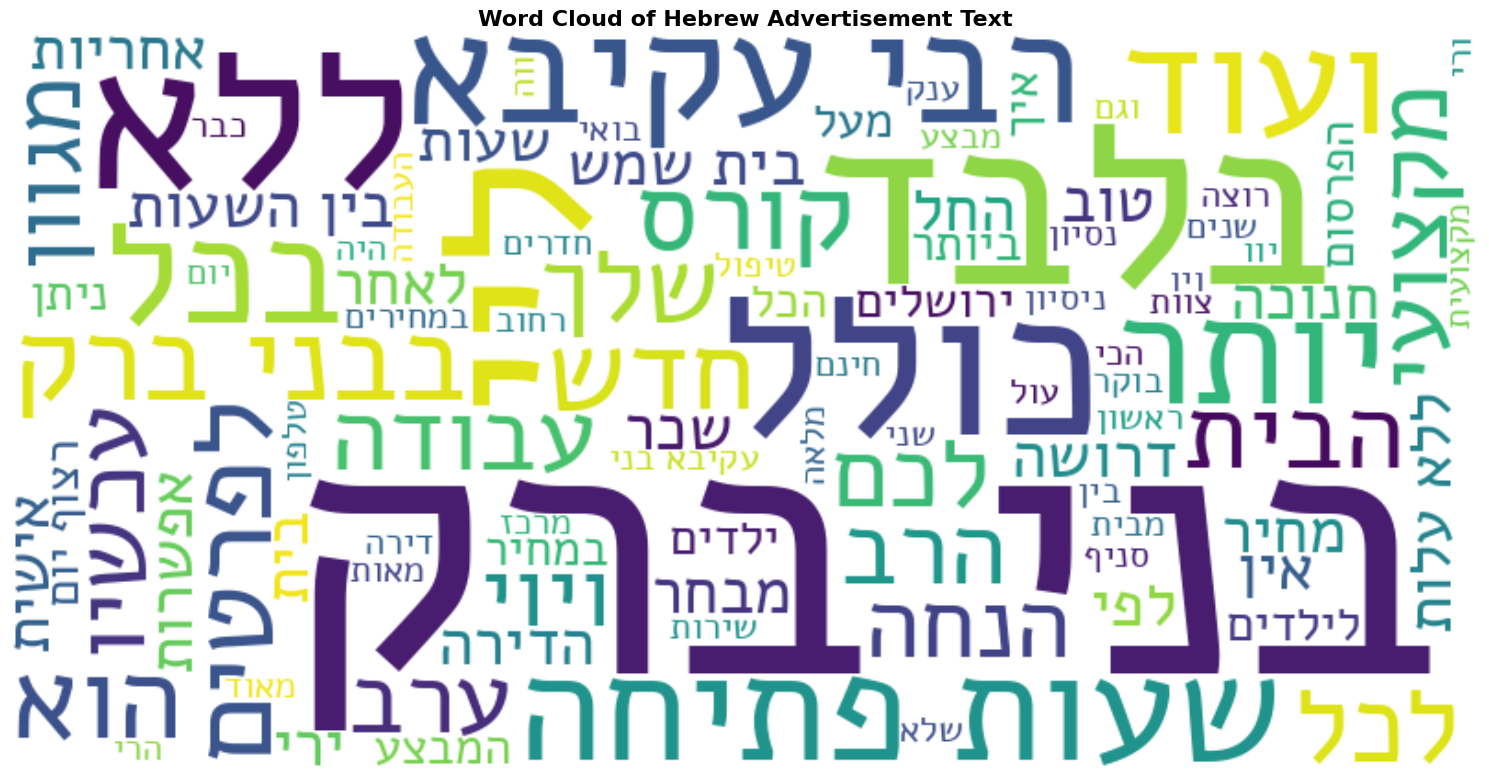

In [ ]:
hebrew_text = ' '.join(df['text_heb_clean'].dropna().astype(str))
hebrew_text = ' '.join([word for word in hebrew_text.split() if len(word) > 2])

if hebrew_text:
    plt.figure(figsize=(15, 8))
    try:
        wordcloud = WordCloud(width=800, height=400,
                            background_color='white',
                            max_words=100,
                            colormap='viridis',
                            font_path='/content/drive/MyDrive/Miki_class/Project/Alef-regular.ttf'
                            ).generate(hebrew_text)
    except:
        # Fallback without Hebrew font
        wordcloud = WordCloud(width=800, height=400,
                            background_color='white',
                            max_words=100,
                            colormap='viridis').generate(hebrew_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Hebrew Advertisement Text', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No Hebrew text data available for word cloud")

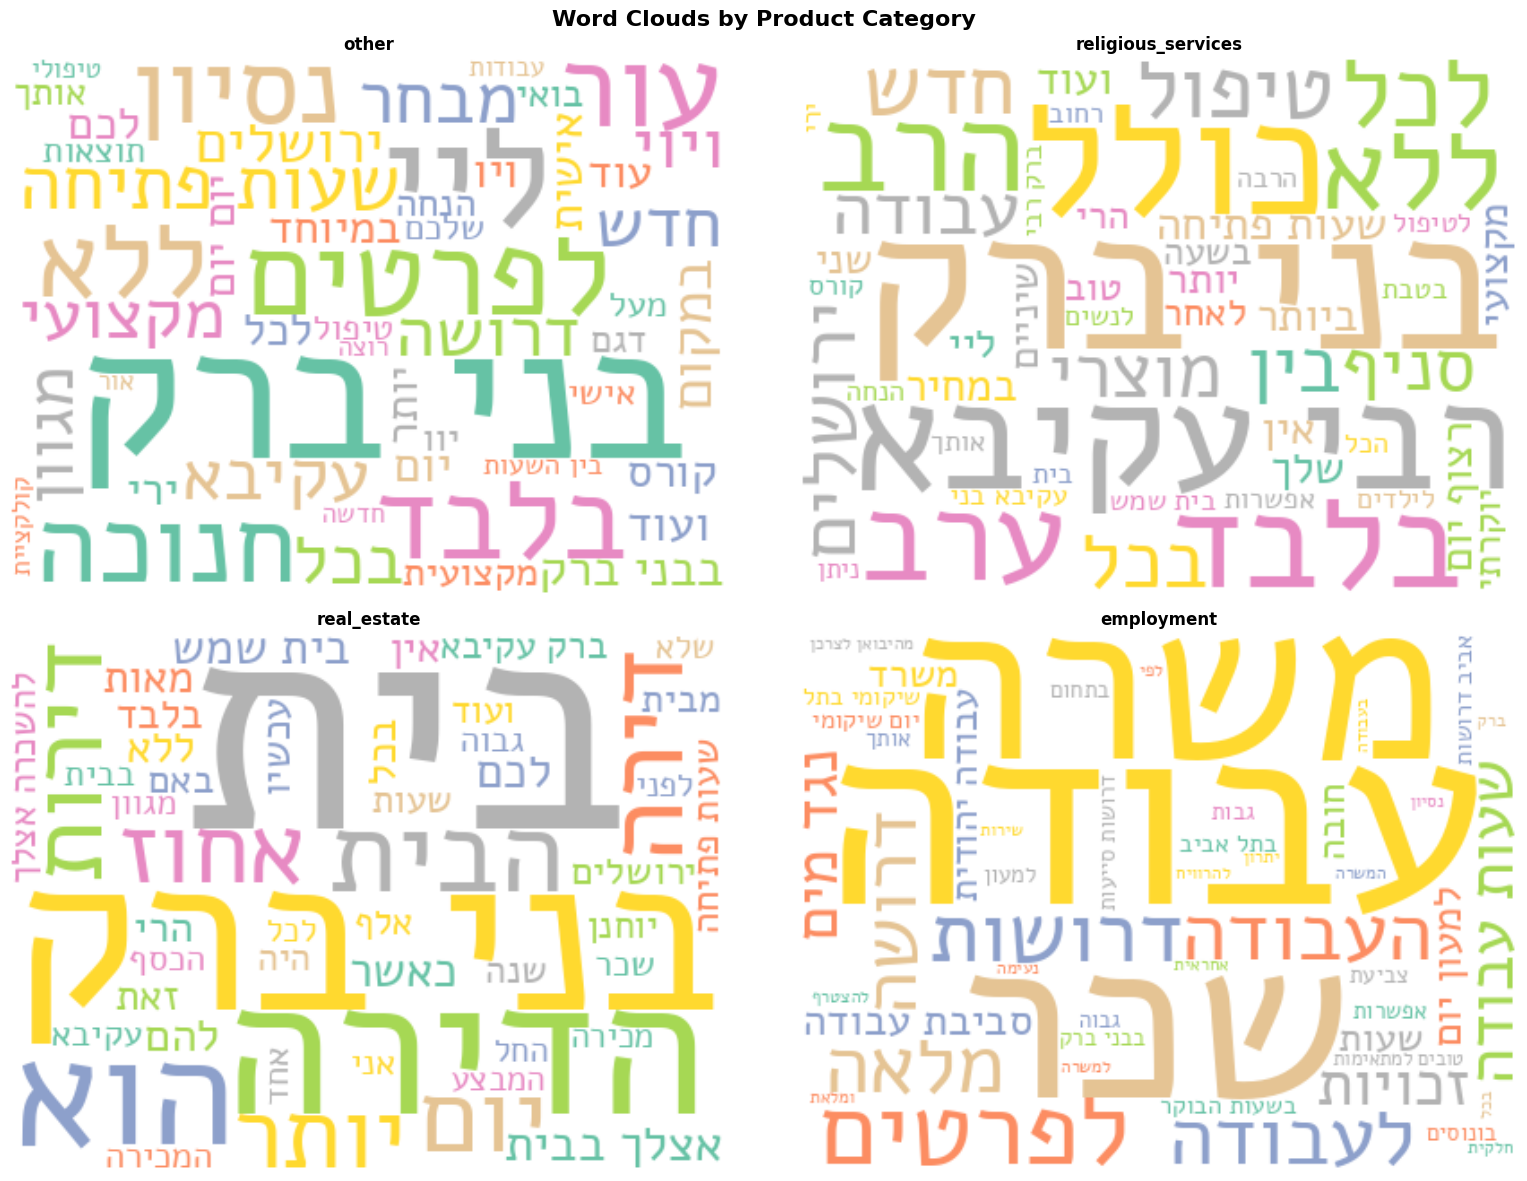

In [ ]:
top_categories = df['product_category'].value_counts().head(4).index

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, category in enumerate(top_categories):
    category_text = ' '.join(df[df['product_category'] == category]['text_heb_clean'].dropna().astype(str))
    category_text = ' '.join([word for word in category_text.split() if len(word) > 2])

    if category_text:
        try:
            wordcloud = WordCloud(width=400, height=300,
                                background_color='white',
                                max_words=50,
                                colormap='Set2',
                                font_path='/content/drive/MyDrive/Miki_class/Project/Alef-regular.ttf'
                                ).generate(category_text)
        except:
            wordcloud = WordCloud(width=400, height=300,
                                background_color='white',
                                max_words=50,
                                colormap='Set2').generate(category_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{category}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Word Clouds by Product Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

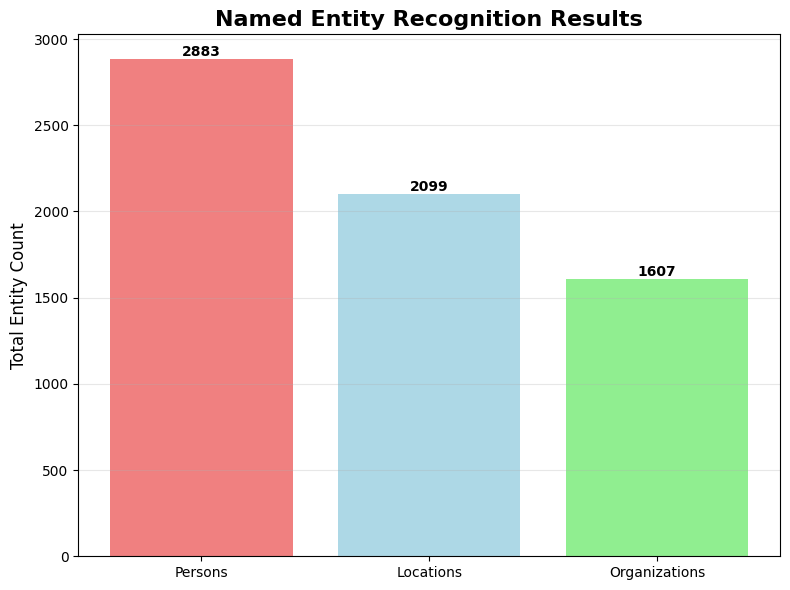

NER Summary:
  Total persons mentioned: 2883
  Total locations mentioned: 2099
  Total organizations mentioned: 1607


In [ ]:
if 'ner_entities' in df.columns:
    # Count total entities
    total_persons = df['person_entities'].sum()
    total_locations = df['location_entities'].sum()
    total_orgs = df['organization_entities'].sum()

    plt.figure(figsize=(8, 6))
    entity_types = ['Persons', 'Locations', 'Organizations']
    entity_counts = [total_persons, total_locations, total_orgs]

    bars = plt.bar(entity_types, entity_counts, color=['lightcoral', 'lightblue', 'lightgreen'])
    plt.title('Named Entity Recognition Results', fontsize=16, fontweight='bold')
    plt.ylabel('Total Entity Count', fontsize=12)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"NER Summary:")
    print(f"  Total persons mentioned: {total_persons}")
    print(f"  Total locations mentioned: {total_locations}")
    print(f"  Total organizations mentioned: {total_orgs}")
else:
    print("NER data not available")

In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

Extracting locations using NER method...


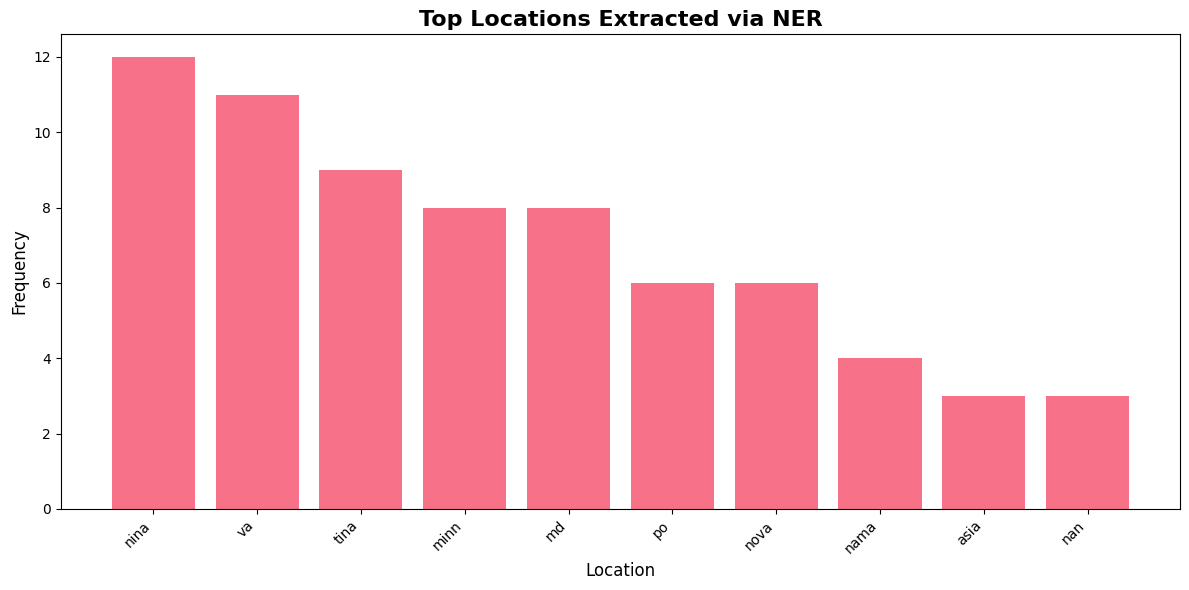

In [ ]:
def extract_locations_ner(text):
    """Extract locations using NER"""
    if pd.isna(text) or not isinstance(text, str):
        return []

    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]
    return locations

# Apply NER location extraction
print("Extracting locations using NER method...")
df['ner_locations'] = df['text_eng_clean'].apply(extract_locations_ner)

# Count NER-extracted locations
ner_location_counts = {}
for locations in df['ner_locations']:
    for location in locations:
        ner_location_counts[location] = ner_location_counts.get(location, 0) + 1

if ner_location_counts:
    plt.figure(figsize=(12, 6))
    top_ner_locations = dict(sorted(ner_location_counts.items(), key=lambda x: x[1], reverse=True)[:10])
    plt.bar(top_ner_locations.keys(), top_ner_locations.values())
    plt.title('Top Locations Extracted via NER', fontsize=16, fontweight='bold')
    plt.xlabel('Location', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No locations found using NER method")

In [16]:
israeli_cities = {
    'ירושלים': 'Jerusalem',
    'תל אביב': 'Tel Aviv',
    'חיפה': 'Haifa',
    'באר שבע': 'Beer Sheva',
    'בני ברק': 'Bnei Brak',
    'פתח תקווה': 'Petah Tikva',
    'נתניה': 'Netanya',
    'אשדוד': 'Ashdod',
    'ראשון לציון': 'Rishon LeZion',
    'חולון': 'Holon',
    'רחובות': 'Rehovot',
    'בת ים': 'Bat Yam',
    'אלעד': 'Elad',
    'מודיעין': 'Modiin',
    'בית שמש': 'Beit Shemesh',
    'ביתר': 'Beitar'
}

In [17]:
def extract_cities_manual(text_heb, text_eng):
    """Extract cities using manual city list"""
    found_cities = []

    # Check Hebrew text
    if isinstance(text_heb, str):
        for heb_city, eng_city in israeli_cities.items():
            if heb_city in text_heb:
                found_cities.append(eng_city)

    # Check English text
    if isinstance(text_eng, str):
        for heb_city, eng_city in israeli_cities.items():
            if eng_city.lower() in text_eng.lower():
                found_cities.append(eng_city)

    return list(set(found_cities))

In [18]:
df['manual_cities'] = df.apply(lambda row: extract_cities_manual(row['text_heb_clean'], row['text_eng_clean']), axis=1)

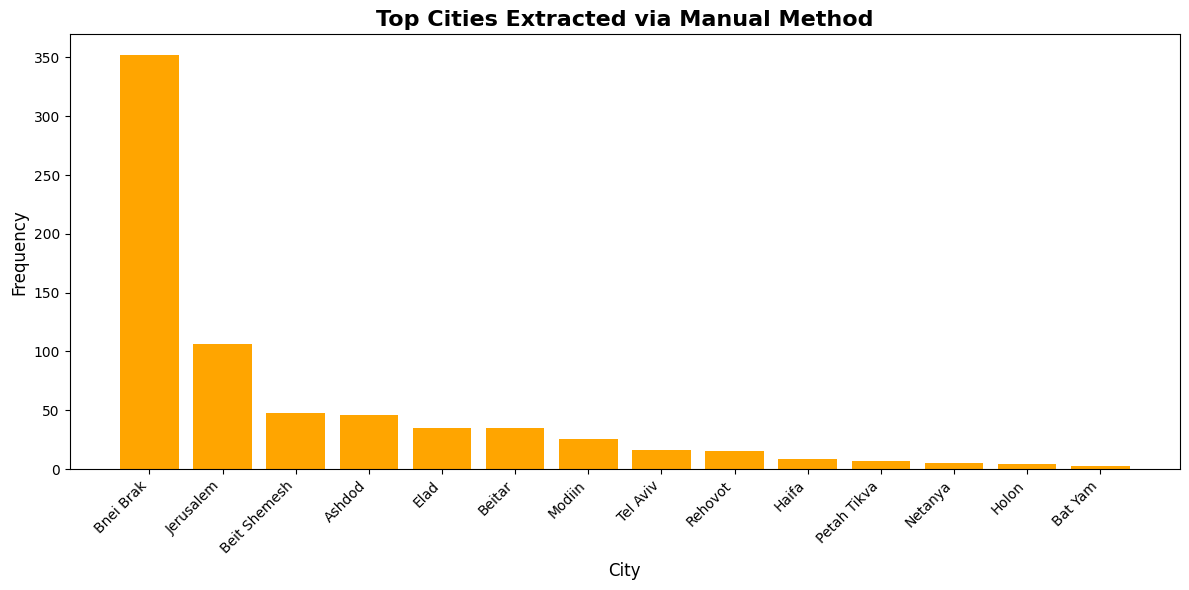

Cities found via manual method:
  Bnei Brak: 352 ads
  Jerusalem: 106 ads
  Beit Shemesh: 48 ads
  Ashdod: 46 ads
  Elad: 35 ads
  Beitar: 35 ads
  Modiin: 26 ads
  Tel Aviv: 16 ads
  Rehovot: 15 ads
  Haifa: 9 ads
  Petah Tikva: 7 ads
  Netanya: 5 ads
  Holon: 4 ads
  Bat Yam: 3 ads


In [19]:
manual_city_counts = {}
for cities in df['manual_cities']:
    for city in cities:
        manual_city_counts[city] = manual_city_counts.get(city, 0) + 1

if manual_city_counts:
    plt.figure(figsize=(12, 6))
    sorted_cities = dict(sorted(manual_city_counts.items(), key=lambda x: x[1], reverse=True))
    plt.bar(sorted_cities.keys(), sorted_cities.values(), color='orange')
    plt.title('Top Cities Extracted via Manual Method', fontsize=16, fontweight='bold')
    plt.xlabel('City', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"Cities found via manual method:")
    for city, count in sorted_cities.items():
        print(f"  {city}: {count} ads")
else:
    print("No cities found using manual method")

In [20]:
city_data = manual_city_counts if manual_city_counts else ner_location_counts

if city_data:
    # Get coordinates for cities
    geolocator = Nominatim(user_agent="ad_analysis")

    city_coords = {}
    for city in city_data.keys():
        try:
            location = geolocator.geocode(f"{city}, Israel")
            if location:
                city_coords[city] = (location.latitude, location.longitude)
        except:
            continue

    if city_coords:
        # Create map centered on Israel
        m = folium.Map(location=[31.5, 35.0], zoom_start=7)

        # Add markers for each city
        for city, (lat, lon) in city_coords.items():
            count = city_data[city]
            folium.CircleMarker(
                location=[lat, lon],
                radius=min(count * 2, 20),  # Scale marker size by frequency
                popup=f"{city}: {count} ads",
                color='red',
                fill=True,
                fillColor='red',
                fillOpacity=0.6
            ).add_to(m)

        # Save and display map
        m.save('/content/drive/MyDrive/Miki_class/Project/ad_locations_map.html')
        print("Interactive map saved as 'ad_locations_map.html'")
        print("Cities with advertisements:")
        for city, count in city_data.items():
            if city in city_coords:
                print(f"  {city}: {count} ads")
    else:
        print("Could not geocode any cities")

Interactive map saved as 'ad_locations_map.html'
Cities with advertisements:
  Jerusalem: 106 ads
  Bnei Brak: 352 ads
  Elad: 35 ads
  Modiin: 26 ads
  Beit Shemesh: 48 ads
  Tel Aviv: 16 ads
  Petah Tikva: 7 ads
  Ashdod: 46 ads
  Netanya: 5 ads
  Rehovot: 15 ads
  Holon: 4 ads
  Beitar: 35 ads
  Bat Yam: 3 ads
  Haifa: 9 ads


In [21]:
m

In [ ]:
# Create network of entity relationships
G = nx.Graph()

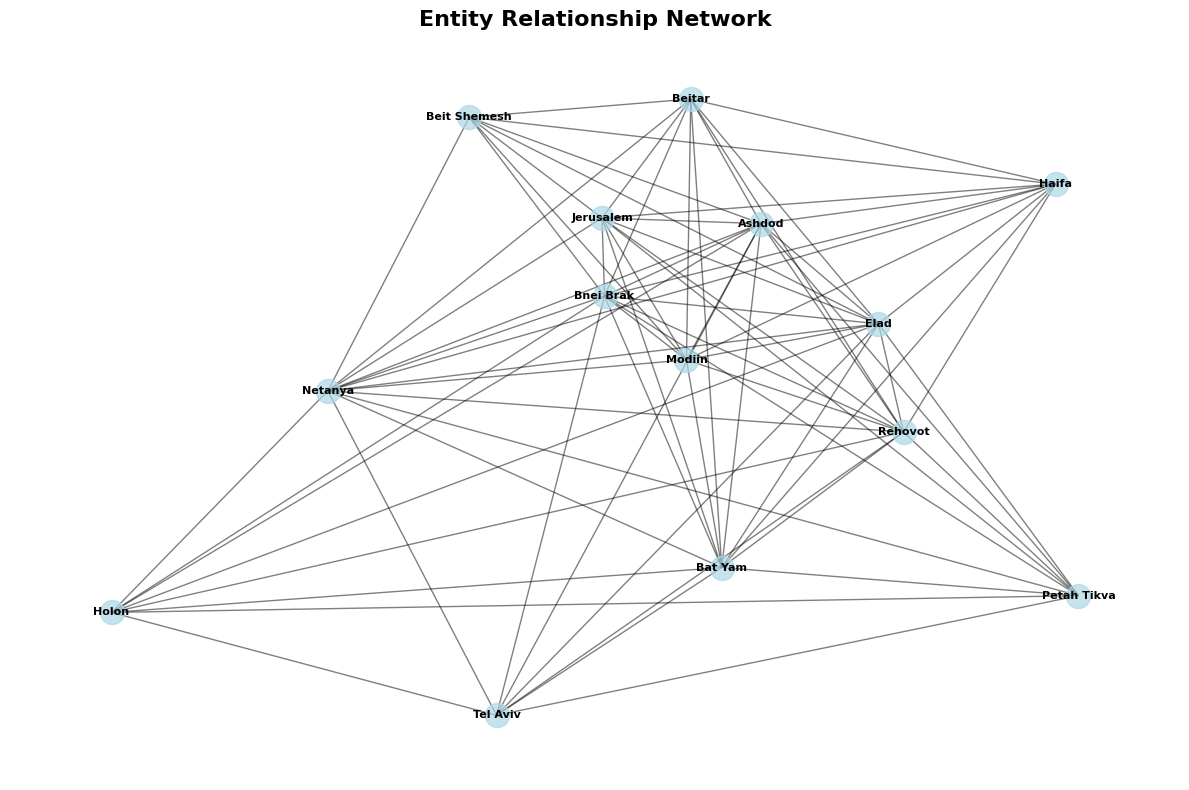

Network stats:
  Nodes (entities): 14
  Edges (relationships): 75


In [ ]:
if 'person_entities' in df.columns:
    # Add some sample relationships based on co-occurrence in same ad
    entity_pairs = []

    for idx, row in df.iterrows():
        entities_in_ad = []

        # Add locations
        if isinstance(row.get('manual_cities'), list):
            entities_in_ad.extend(row['manual_cities'])

        # Create pairs from entities in same ad
        for i in range(len(entities_in_ad)):
            for j in range(i+1, len(entities_in_ad)):
                entity_pairs.append((entities_in_ad[i], entities_in_ad[j]))

    # Add edges to graph
    for pair in entity_pairs:
        if G.has_edge(pair[0], pair[1]):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

    if len(G.nodes()) > 0:
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Draw network
        nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                              node_size=300, alpha=0.7)
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)

        plt.title('Entity Relationship Network', fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"Network stats:")
        print(f"  Nodes (entities): {len(G.nodes())}")
        print(f"  Edges (relationships): {len(G.edges())}")
    else:
        print("Not enough data for network analysis")

In [ ]:
feature_columns = ['width', 'height', 'aspect_ratio', 'total_colors',
                  'text_heb_length', 'text_eng_length']

Applying t-SNE for image similarity visualization...


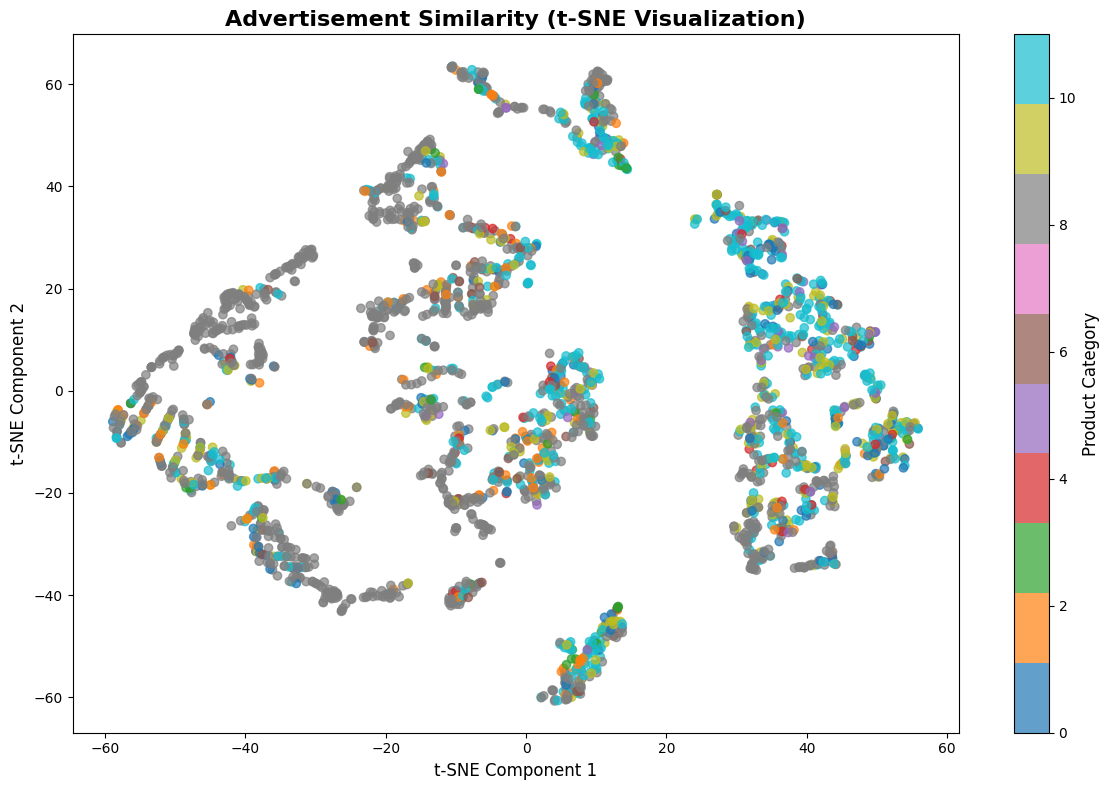

In [ ]:
available_features = [col for col in feature_columns if col in df.columns]

if len(available_features) >= 3:
    # Prepare feature matrix
    feature_matrix = df[available_features].fillna(0)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    # Apply t-SNE
    print("Applying t-SNE for image similarity visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df)//4))
    tsne_results = tsne.fit_transform(scaled_features)

    # Create t-SNE plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=df['product_category'].astype('category').cat.codes,
                         cmap='tab10', alpha=0.7)
    plt.title('Advertisement Similarity (t-SNE Visualization)', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)

    # Add colorbar with category names
    cbar = plt.colorbar(scatter)
    cbar.set_label('Product Category', fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical features for t-SNE analysis")

In [ ]:
print("FINAL ANALYSIS SUMMARY")
print(f"\nGENDER TARGETING:")
gender_stats = df['gender_target'].value_counts()
for gender, count in gender_stats.items():
    print(f"  {gender}: {count} ads ({count/len(df)*100:.1f}%)")

print(f"\nCATEGORY BREAKDOWN:")
top_categories = df['product_category'].value_counts().head(5)

for category, count in top_categories.items():
    print(f"  {category}: {count} ads ({count/len(df)*100:.1f}%)")
print(f"\nTEMPORAL INSIGHTS:")
print(f"  Holiday-adjacent ads: {df['is_near_holiday'].sum()} ({df['is_near_holiday'].sum()/len(df)*100:.1f}%)")
print(f"  Pre-Shabbat issues: {df['is_pre_shabbat'].sum()} ({df['is_pre_shabbat'].sum()/len(df)*100:.1f}%)")
print(f"  Ads with Shabbat content: {df['has_shabbat_terms'].sum()} ({df['has_shabbat_terms'].sum()/len(df)*100:.1f}%)")

print(f"\nVISUAL CHARACTERISTICS:")
print(f"  Greyscale ads: {df['is_greyscale'].sum()}")
print(f"  Average colors per ad: {df['total_colors'].mean():.1f}")
print(f"  Average aspect ratio: {df['aspect_ratio'].mean():.2f}")

if 'has_people' in df.columns:
    print(f"\nOBJECT DETECTION RESULTS:")
    print(f"  Ads with people: {df['has_people'].sum()}")
    print(f"  Ads with food: {df['has_food'].sum()}")
    print(f"  Ads with furniture: {df['has_furniture'].sum()}")
    print(f"  Ads with electronics: {df['has_electronics'].sum()}")

if len(df_with_prices) > 0:
    print(f"\nPRICING INSIGHTS:")
    print(f"  Ads with prices: {len(df_with_prices)} ({len(df_with_prices)/len(df)*100:.1f}%)")
    print(f"  Average price: {df_with_prices['avg_price'].mean():.2f} NIS")
    print(f"  Price range: {df_with_prices['min_price'].min():.2f} - {df_with_prices['max_price'].max():.2f} NIS")

if manual_city_counts:
    print(f"\nGEOGRAPHIC DISTRIBUTION:")
    print(f"  Cities mentioned: {len(manual_city_counts)}")
    top_city = max(manual_city_counts, key=manual_city_counts.get)
    print(f"  Most mentioned city: {top_city} ({manual_city_counts[top_city]} ads)")


FINAL ANALYSIS SUMMARY

GENDER TARGETING:
  neutral: 1685 ads (61.8%)
  male: 774 ads (28.4%)
  female: 266 ads (9.8%)

CATEGORY BREAKDOWN:
  other: 1427 ads (52.4%)
  religious_services: 544 ads (20.0%)
  real_estate: 248 ads (9.1%)
  employment: 131 ads (4.8%)
  education: 99 ads (3.6%)

TEMPORAL INSIGHTS:
  Holiday-adjacent ads: 1000 (36.7%)
  Pre-Shabbat issues: 0 (0.0%)
  Ads with Shabbat content: 71 (2.6%)

VISUAL CHARACTERISTICS:
  Greyscale ads: 5
  Average colors per ad: 5.0
  Average aspect ratio: 0.88

OBJECT DETECTION RESULTS:
  Ads with people: 524
  Ads with food: 121
  Ads with furniture: 98
  Ads with electronics: 145

PRICING INSIGHTS:
  Ads with prices: 533 (19.6%)
  Average price: 1009.94 NIS
  Price range: 1.00 - 47000.00 NIS

GEOGRAPHIC DISTRIBUTION:
  Cities mentioned: 14
  Most mentioned city: Bnei Brak (352 ads)
